# **DAVIDE BULOTTA ------ Assignment 2**

In [1]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import silhouette_score
import matplotlib.patches as patches
from sklearn.cluster import KMeans
import matplotlib.colors as matcolors
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 as cv
import os

# Read Dataset

The images were read using OpenCV.

All characteristics are extrapolated using **SIFT** from OpenCV

I've decided to use the mask to extract all features, inside the horse's body

In [2]:
# Get the sift descriptor of the image with the mask
def getDesImage(idx:int, sift:cv.SIFT, test:bool=False):
    # Read the image and mask
    img_name = 'dataset/horse/horse' + str(idx).zfill(3) + '.png'
    mask_name = 'dataset/mask/horse' + str(idx).zfill(3) + '.png'
    img = cv.imread(img_name)
    mask = cv.imread(mask_name, cv.IMREAD_GRAYSCALE) # Read the mask as grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)       # Convert the image to grayscale
    # Get the sift descriptor without mask
    kp, des_img = sift.detectAndCompute(gray, None)
    img_new = cv.drawKeypoints(gray, kp, img)        # Draw the keypoints on the image
    cv.imwrite(f'output/{'test' if test else 'train'}/sift_{idx}_unmask.png', img_new)
    # Get the sift descriptor
    kp, des_img = sift.detectAndCompute(gray, mask)
    img_new = cv.drawKeypoints(gray, kp, img)        # Draw the keypoints on the image
    cv.imwrite(f'output/{'test' if test else 'train'}/sift_{idx}.png', img_new)
    return des_img, kp

As requested all the images compose the train set except the last ten for the test set

In [3]:
# SIFT (Scale-Invariant Feature Transform)
# https://docs.opencv.org/4.5.2/da/df5/tutorial_py_sift_intro.html
sift = cv.SIFT.create() # SIFT detector
des_list_train = []     # List of descriptors for training set
des_list_test = []      # List of descriptors for test set
kp_list_test = []      # List of keypoints for training set
# Create output directory
os.makedirs('output', exist_ok=True)
# Create output subdirectories        
os.makedirs('output/train', exist_ok=True)
os.makedirs('output/test', exist_ok=True)

# Extract SIFT features
# 1-316:    Training set
# 317-327:  Test set
for idx in tqdm(range(1,317), desc='Extracting SIFT features [Train set]'): # 1-316
    # Get the SIFT descriptor of the image
    des, _ = getDesImage(idx, sift)
    if des is not None:
        des_list_train.append(des)
    
for idx in tqdm(range(317,328), desc='Extracting SIFT features [Test set]'): # 317-327
    # Get the SIFT descriptor of the image
    des, kp = getDesImage(idx, sift, True)
    if des is not None:
        des_list_test.append(des)
    kp_list_test.append(kp)

Extracting SIFT features [Test set]: 100%|██████████| 11/11 [00:00<00:00, 25.53it/s]


Here I've placed a little example to show how we see the horse with the mask applied. Of course, this will help me to learn how it works

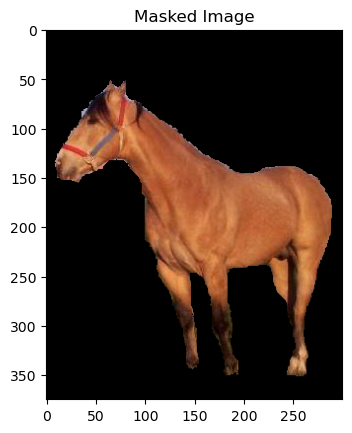

In [4]:
image = cv.imread('dataset/horse/horse020.png')
mask = cv.imread('dataset/mask/horse020.png', cv.IMREAD_GRAYSCALE)
masked_image = cv.bitwise_and(image, image, mask=mask)
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Masked Image')
plt.show()

# K-Means

I've started from 1 to 40 as K and I applied the elbow method calculating the sum of squared errors (SSE)

That's helped me to find the **optimal K**

100%|██████████| 40/40 [00:26<00:00,  1.51it/s]


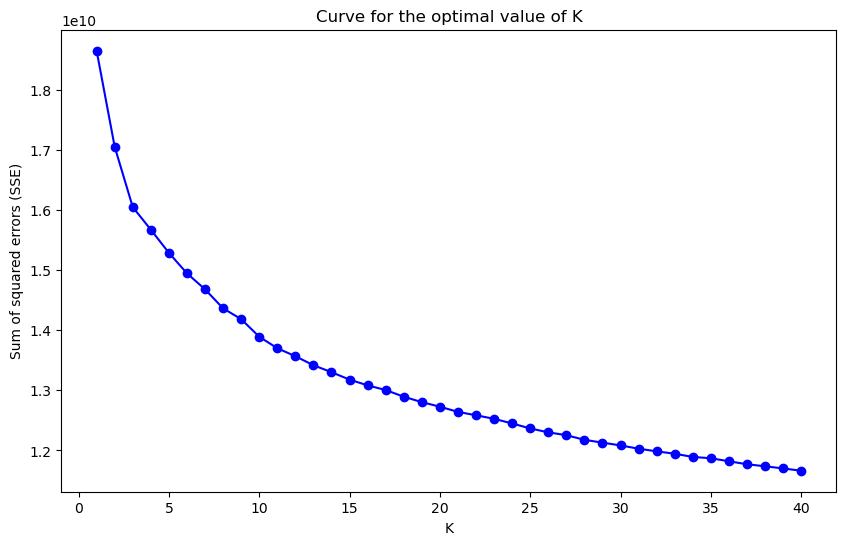

In [5]:
# Stack arrays in sequence vertically
# https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
descriptors_train = np.vstack(des_list_train)

sse = []    # Sum of squared errors list
K_range = range(1, 41)  # In range 1 to 40
for K in tqdm(K_range):
    # Train the KMeans model
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=K, random_state=0).fit(descriptors_train)
    # Append the sum of squared errors to the list
    sse.append(kmeans.inertia_)

# Plot the curve for the optimal value of K
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, 'bo-')
plt.title('Curve for the optimal value of K')
plt.xlabel('K')
plt.ylabel('Sum of squared errors (SSE)')
plt.show()

As seen up here, the curve flattens after (15-20)K, we can find the optimal K by calculating the first and second derivative of SSE

Of course this is a simple way to do it

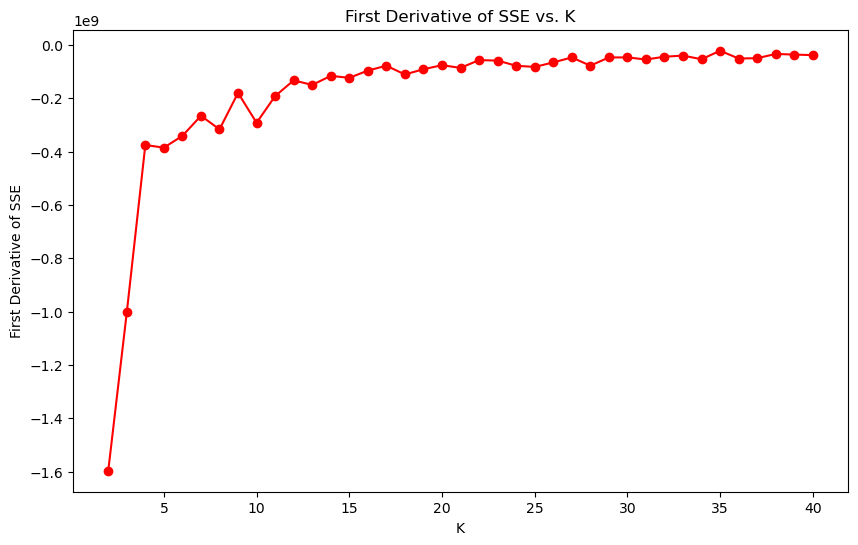

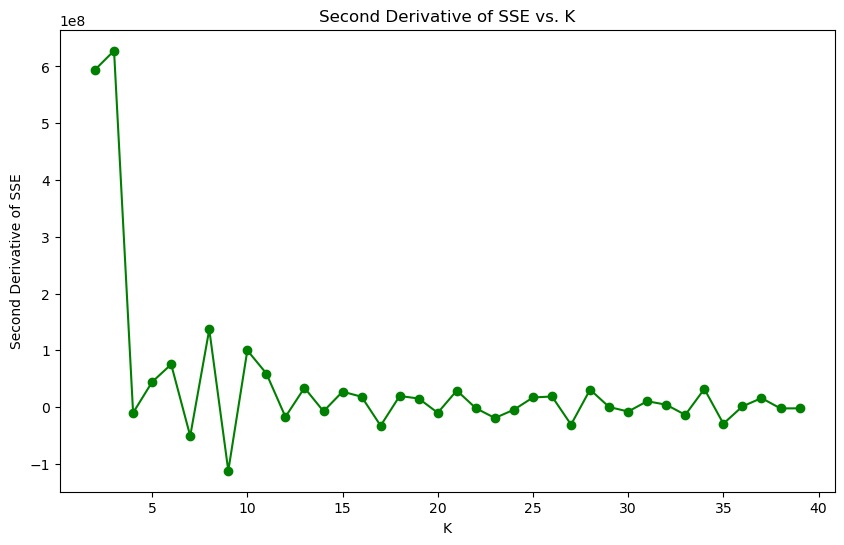

In [6]:
# Calculate the first derivative
first_derivative = np.diff(sse)
# Calculate the second derivative
second_derivative = np.diff(first_derivative)
# Adjust the range
K_range_adjusted = range(2, 40)

# Plot the first derivative
plt.figure(figsize=(10, 6))
plt.plot(K_range[1:], first_derivative, 'ro-')
plt.title('First Derivative of SSE vs. K')
plt.xlabel('K')
plt.ylabel('First Derivative of SSE')
plt.show()

# Plot the second derivative
plt.figure(figsize=(10, 6))
plt.plot(K_range_adjusted, second_derivative, 'go-')
plt.title('Second Derivative of SSE vs. K')
plt.xlabel('K')
plt.ylabel('Second Derivative of SSE')
plt.show()


On these plots we can notice the optimal K is located between 5-15, then the K starts to flatten

Let's take a closer look at the curve in the interested interval

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


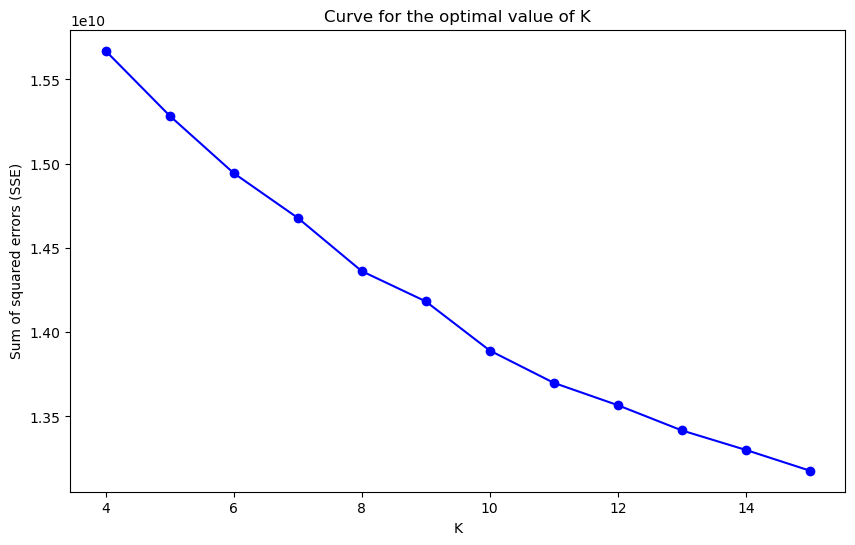

In [7]:
sse = []
K_range = range(4, 16)  # In range 4 to 14
for K in tqdm(K_range):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(descriptors_train)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, 'bo-')
plt.title('Curve for the optimal value of K')
plt.xlabel('K')
plt.ylabel('Sum of squared errors (SSE)')
plt.show()

In last for know what is the best choice of K we can use the **silhouette score**

Personal info: The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

Calculating Silhouette Scores: 100%|██████████| 12/12 [21:35<00:00, 107.96s/it]


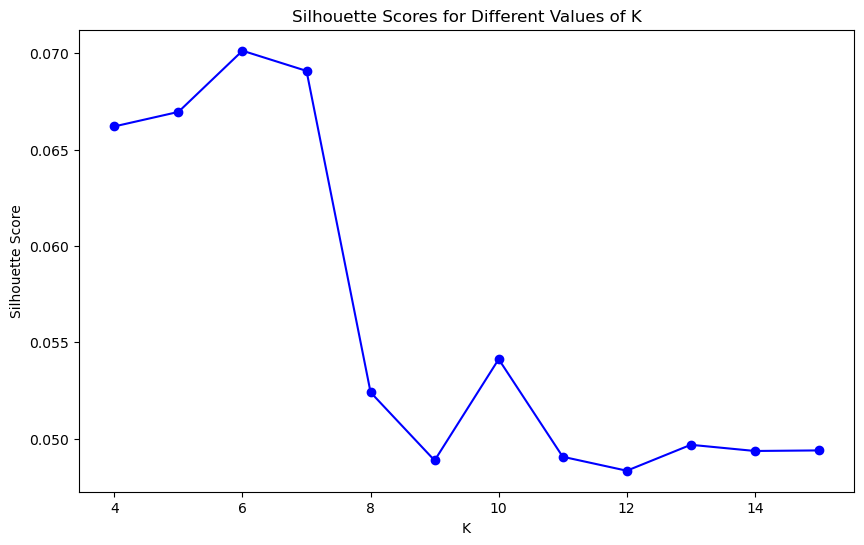

In [8]:
# Calculate the silhouette scores
K_range_silhouette = range(4, 16)
silhouette_scores = [] # List of silhouette scores

# Calculate the silhouette scores for different values of K
for K in tqdm(K_range_silhouette, desc='Calculating Silhouette Scores'):
    # Train the KMeans model
    kmeans = KMeans(n_clusters=K, random_state=0).fit(descriptors_train)
    # Get the labels
    clusters = kmeans.labels_
    # Calculate the silhouette score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
    silhouette_avg = silhouette_score(descriptors_train, clusters)
    silhouette_scores.append(silhouette_avg) # Append the silhouette score to the list

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'bo-')
plt.title('Silhouette Scores for Different Values of K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

The major value (most near to 1) is 6, after this the score decreases.

We found our optimal **K = 6**.

In [9]:
K = 6 # Number of clusters

kmeans = KMeans(n_clusters=K, random_state=0) #initialize the KMeans object
kmeans.fit(descriptors_train) #cluster the SIFT descriptors
kmeans_labels = kmeans.labels_ #get the labels# Draw the keypoints on the imageof the clusters

For visual feedback, we can see here the distribution of the clusters as compared to original data.

Text(0.5, 1.0, 'K-means Clustering')

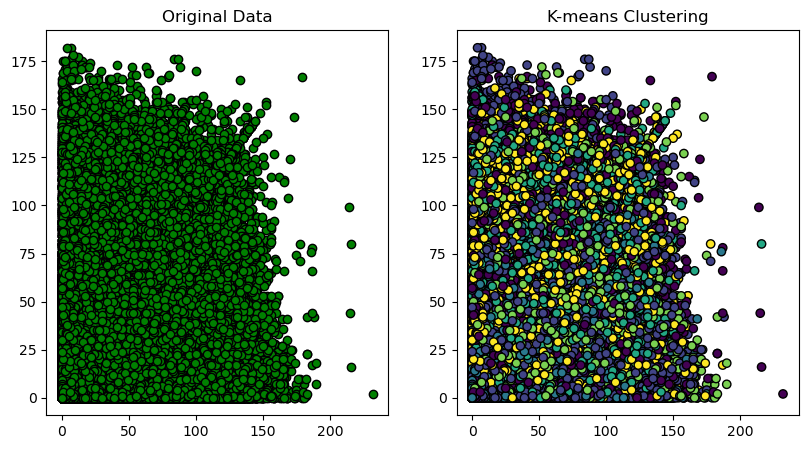

In [10]:
# Scatter plot dei dati originali
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(descriptors_train[:, 0], descriptors_train[:, 1], c='green', edgecolor='k')
plt.title('Original Data')

# Scatter plot del clustering K-means
plt.subplot(1, 3, 2)
plt.scatter(descriptors_train[:, 0], descriptors_train[:, 1], c=kmeans_labels, edgecolor='k')
plt.title('K-means Clustering')

# Bag of Visual Terms

For each descriptor list **(des_list)**, we will generate a corresponding list of histograms. 

Each histogram in this list represents the cluster distribution for a specific **document (image)**.

In [11]:
histograms_train = [] # List of histograms for training set
histograms_test = []  # List of histograms for test set

# Calculate the histograms for the training and test sets
for descriptors in des_list_train:
    # Predict the cluster for each descriptor
    clusters = kmeans.predict(descriptors)
    # Calculate the histogram
    # https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
    # https://numpy.org/doc/stable/reference/generated/numpy.arange.html
    hist, _ = np.histogram(clusters, bins=np.arange(kmeans.n_clusters + 1))
    # Append the histogram to the list
    histograms_train.append(hist)

for descriptors in des_list_test:
    # Predict the cluster for each descriptor
    clusters = kmeans.predict(descriptors)
    # Calculate the histogram
    hist, _ = np.histogram(clusters, bins=np.arange(kmeans.n_clusters + 1))
    # Append the histogram to the list
    histograms_test.append(hist)



# Convert the list of histograms to a numpy array
X_train = np.array(histograms_train)
X_test = np.array(histograms_test)

# LDA Model

Finally, we can train our LDA model with the train set using 10 like number of topics

In [12]:
# Train the LDA model
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
model = LDA(n_components=5, random_state=0, max_iter=100, learning_method='batch')
model.fit(X_train)

LatentDirichletAllocation(max_iter=100, n_components=5, random_state=0)

/tmp/ipykernel_21346/3036788039.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_topics)  # Color map for the topics


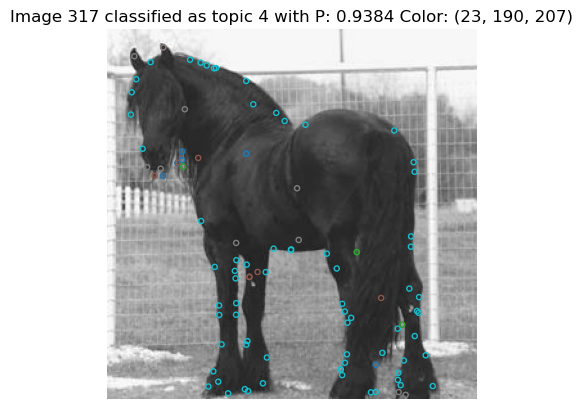

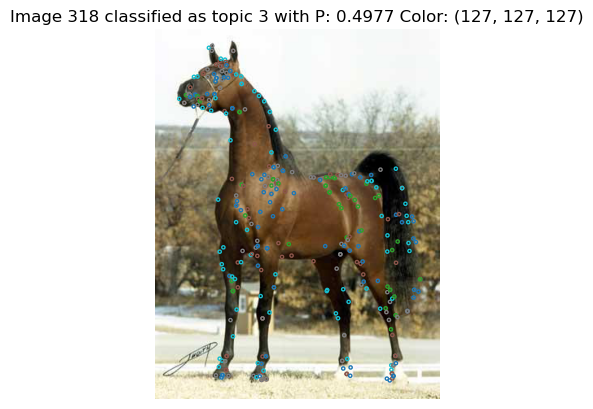

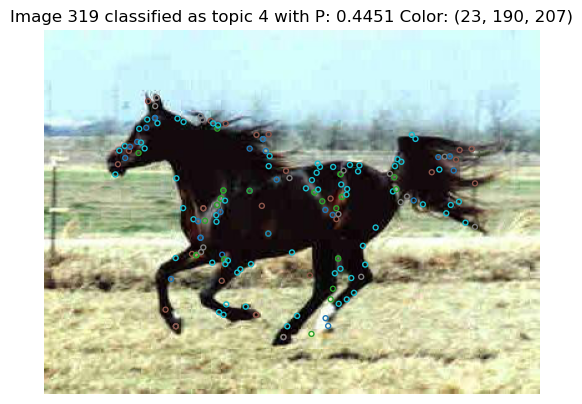

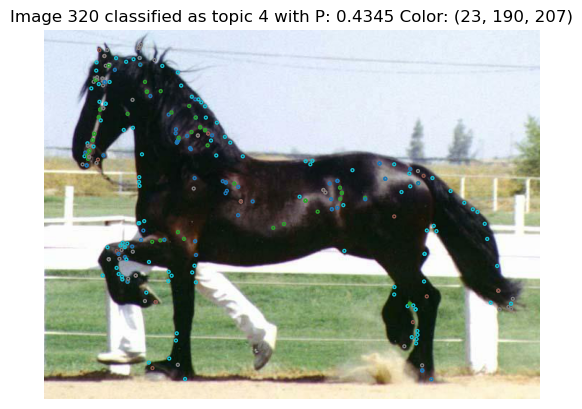

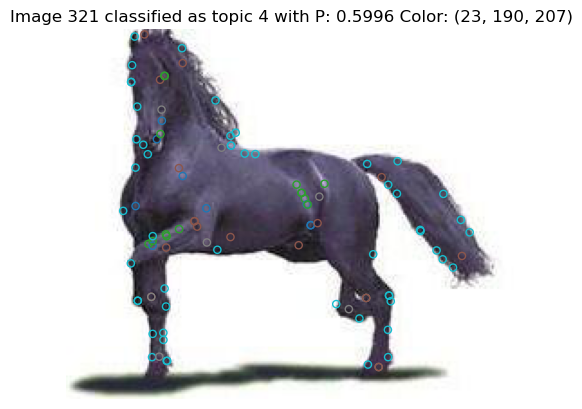

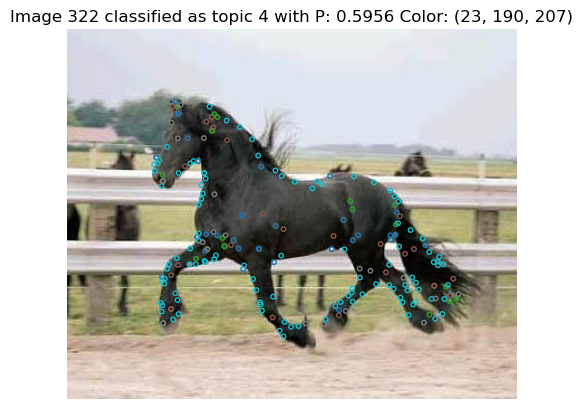

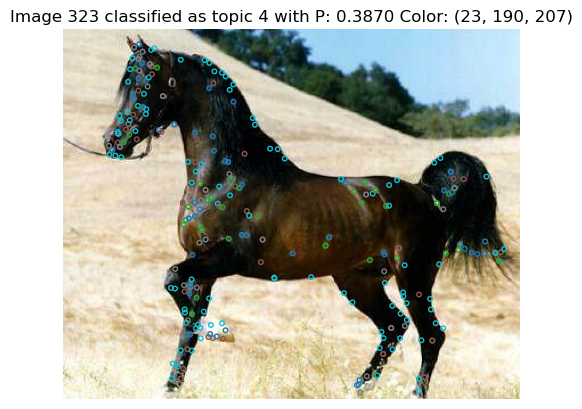

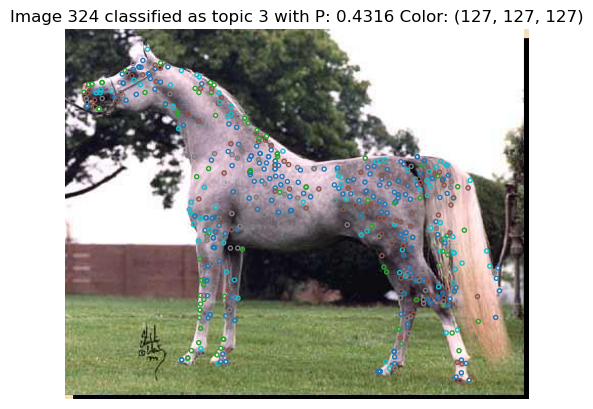

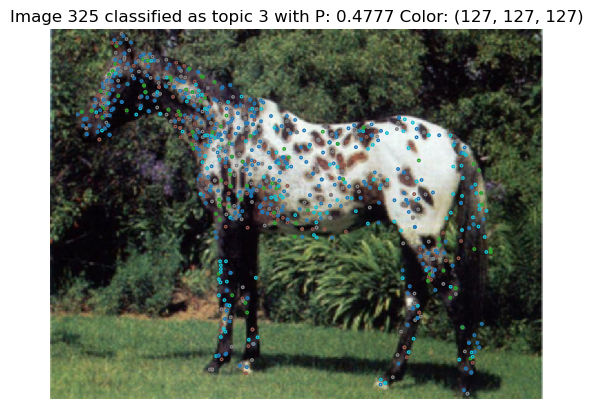

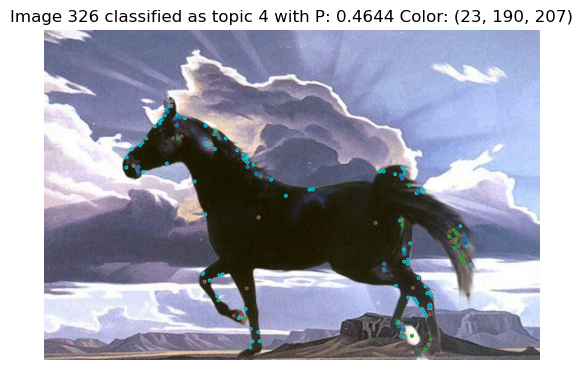

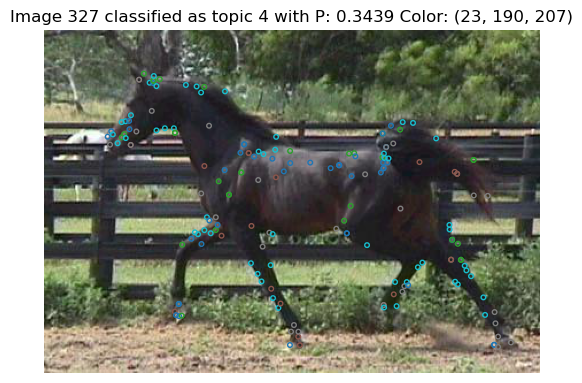

In [13]:
n_topics = 5  # Number of topics in LDA
colors = plt.cm.get_cmap('tab10', n_topics)  # Color map for the topics

topic_distributions_test = model.transform(X_test)  # Get the topic distributions for the test set

for idx, (keypoints, descriptors) in enumerate(zip(kp_list_test, des_list_test)):
    img_index = 317 + idx                                # Adjusting the starting index
    img_name = f'dataset/horse/horse{img_index:03}.png'  # Name of the image
    image = cv.imread(img_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Predict clusters for each descriptor
    clusters = kmeans.predict(descriptors)

    # Create a new figure
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Calculate the most probable topic for each cluster
    topic_for_cluster = {}
    for cluster in np.unique(clusters):
        hist = np.zeros(kmeans.n_clusters) # Initialize the histogram
        hist[cluster] = 1                  # Set the cluster to 1 in the histogram
        topic_for_cluster[cluster] = np.argmax(model.transform([hist]))

    # Add a circle for each keypoint with the color of the topic
    for kp, cluster in zip(keypoints, clusters):
        top_topic = topic_for_cluster[cluster]  # Get the topic from precomputed dictionary
        color = colors(top_topic)               # Get the color for the topic
        # Add the circle to the plot
        circ = patches.Circle((kp.pt[0], kp.pt[1]), radius=2, color=color, fill=False)
        ax.add_patch(circ)

    top_topic = topic_distributions_test[idx].argmax()                                 # Most probable topic for the image
    color = colors(top_topic)                                                          # Get the color for the topic
    rgb_str = f'({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})' # Convert to RGB string

    # Show the image
    plt.title(f'Image {img_index} classified as topic {top_topic} with P: {topic_distributions_test[idx][top_topic]:.4f} Color: {rgb_str}')
    plt.axis('off')
    plt.show()